In [1]:
version = "REPLACE_PACKAGE_VERSION"

# Assignment 3: Classification and Evaluation

In this assignment we will build several classification models and calculate some useful metrics for gauging the performance of these models. The scenario we'll address is "spam" e-mail detection: a very important, widely-used supervised machine learning task that attempts to find unsolicited, mass-produced messages that have irrelevant and/or inappropriate content (often mass marketing or attempts at fraud). These are sometimes called "spam filters".

We treat this task as a binary classification problem: detecting if an email is "spam" (Class == 1) or not (Class == 0, a regular/good e-mail). Email systems will typically automatically move messages detected as "spam" to a "Spam" or "Deleted" folder so the user will not have to read them in their regular inbox.

In this setup, a *false positive* would mark a regular/good e-mail as spam. The key aspect of the "spam" scenario is that false positives are obviously very undesirable, because these would cause people to potentially lose valuable "good" messages. So we want a highly precise spam filter that has few/no false positives, but as we'll see, as a consequence it may let more spam through the filter. This is a classic precision / recall tradeoff, which you'll investigate below.

In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

### Question 1. (10 pts)

Import the data from `assets/spam.csv`. What is the ratio of the counts of regular (class == 0) to spam (Class == 1) observations in the entire dataset? 

*This function should return a positive float less than 10.* 

In [3]:
def answer_one():
    frac = None
    
    df = pd.read_csv('assets/spam.csv')
    r = len(df[df['Class']==0])/len(df[df['Class']==1])
    
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return r

In [4]:
df = pd.read_csv('assets/spam.csv')
ratio = len(df[df['Class']==0])/len(df[df['Class']==1])
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V49,V50,V51,V52,V53,V54,V55,V56,V57,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [5]:
# Autograder tests

stu_ans = answer_one()
assert isinstance(stu_ans, float), "Q1: Your function should return a float. "
assert 0.0 <= stu_ans <= 10.0, "Q1: Your answer must be between 0 and 10. "

del stu_ans

Now prepare the data: we break into training and testing sets as usual. But there's another critical step, since we're going to be using *regularized* classification methods on this data. We must first *perform feature normalization so that all features are on a standardized scale.*  We do this by applying the StandardScalar class from sklearn.preprocessing.

The details of how we do this are important. You must *first* split the data into training and test sets, and *only after the split*, do the feature normalization. This is to avoid giving information about the range of variables in the test split to the training split, which would be a form of data leakage.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("assets/spam.csv")

X = df.iloc[:, :-1]
y = df.iloc[:, -1]


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Use X_train, X_test, y_train, y_test for all of the following questions.
# Also, X_train_raw and X_test_raw will be useful for Question 7.

### Question 2. (15 pts)

We've seen that so-called *dummy* classifiers can be used as a simple *sanity-check* baseline against which to compare real classifier performance. If your classifier can't do much better than the dummy classifier, you probably have more work to do.

Using `X_train`, `X_test`, `y_train`, and `y_test`, train two dummy classifiers: (A) one that respects the training set's label distribution and (B) one that classifies everything as the majority class of the training data. Where appropriate, make sure to set the *random_state* parameter to zero. 

Then on the test set, for each of the classifiers A and B, compute precision, recall, and accuracy. Report your results as a single tuple as shown below. Once you have the results, it's instructive to compare these two different types of dummy baselines to understand why they are different.

*This function should a return a tuple of six floats, like so:*

*`(precision_score_A, recall_score_A, accuracy_score_A, precision_score_B, recall_score_B, accuracy_score_B)`.*

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, accuracy_score

def answer_two():
    preA, recA, accA, preB, recB, accB = None, None, None, None, None, None
    
    dummy_A = DummyClassifier(strategy = 'stratified',random_state = 0).fit(X_train, y_train)
    Apreds = dummy_A.predict(X_test)
    
    preA = precision_score(y_test, Apreds)
    recA = recall_score(y_test, Apreds)
    accA = accuracy_score(y_test, Apreds)
    
    dummy_B = DummyClassifier(strategy = 'most_frequent',random_state = 0).fit(X_train, y_train)
    Bpreds = dummy_B.predict(X_test)
    
    preB = precision_score(y_test, Bpreds)
    recB = recall_score(y_test, Bpreds)
    accB = accuracy_score(y_test, Bpreds)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return preA, recA, accA, preB, recB, accB


In [8]:
# Autograder tests

stu_ans = answer_two()

assert isinstance(stu_ans, tuple), "Q2: Your function should return a tuple. "
assert len(stu_ans) == 6, "Q2: The length of your returned tuple should be 6. "
assert all([isinstance(item, float) for item in stu_ans]), "Q2: Your tuple should only contain floats. "
#assert isinstance(stu_ans[0], float) and isinstance(stu_ans[1], float) and isinstance(stu_ans[2], float) and isinstance(stu_ans[3], float) and isinstance(stu_ans[4], float) and isinstance(stu_ans[5], float), "Q2: Your tuple should only contain floats. "

del stu_ans

### Question 3. (15 pts)

Using `X_train`, `X_test`, `y_train`, and `y_test`, train an SVC classifier with the default hyper-parameters. What are the accuracy, recall and precision of this classifier on the testing set?

*This function should a return a tuple of three floats, i.e. `(accuracy score, recall score, precision score)`.*

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score

def answer_three():
    acc, rec, pre = (None, ) * 3 # accuracy, recall and precision
    
    svm = SVC(kernel='rbf', C=1).fit(X_train, y_train)
    svm_predicted = svm.predict(X_test)
    
    acc = accuracy_score(y_test,svm_predicted)
    rec = recall_score(y_test,svm_predicted)
    pre = precision_score(y_test,svm_predicted)
    
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return acc, rec, pre

In [10]:
# Autograder tests

stu_ans = answer_three()

assert isinstance(stu_ans, tuple), "Q3: Your function should return a tuple. "
assert len(stu_ans) == 3, "Q3: The length of your returned tuple should be 3. "
assert all([isinstance(item, float) for item in stu_ans]), "Q3: Your tuple should only contain floats. "

del stu_ans

### Question 4. (20 pts)

Train an SVC classifier with default hyper-parameters except for `{"C": 1e9, "gamma": 1e-8}`. What is the confusion matrix on the testing set if we use a threshold of `-100` for the decision function? That is, we classify instances with a raw score greater than -100 under the decision function as Class 1. 

*This function should return a 2x2 numpy array of 4 integers.*

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

def answer_four():
    conf_mtrx = None
    
    svm = SVC(kernel='rbf', C=1e9, gamma = 1e-8).fit(X_train, y_train)
    svm_predicted = svm.decision_function(X_test) 
    
    svm_predicted = np.where(svm_predicted > -100, 1, 0)
    
    conf_mtrx = confusion_matrix(y_test, svm_predicted)

    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return conf_mtrx

In [12]:
# Autograder tests

stu_ans = answer_four()

assert isinstance(stu_ans, np.ndarray), "Q4: Your function should return a np.ndarray. "
assert stu_ans.shape == (2, 2), "Q4: Your confusion matrix should be of size 2x2. "

del stu_ans

### Question 5. (20 pts)

Train a logistic regression spam e-mail classifier with default hyper-parameters using `X_train` and `y_train`. Create a precision-recall curve and a Receiver Operating Characteristic (ROC) curve using `y_test` and the probability estimates of being "spam" for X_test.

- Based on the precision-recall curve, what is the recall when the precision is $0.90$?

- Based on the ROC curve, what is the true positive rate when the false positive rate is $0.10$?

Write a function to return the answers. Note you can use a pure programming approach to get the answers: you don't have to actually "plot" the curves. However, it's quite instructive to plot these curves to understand just how e.g. precision and recall trade off. So you can plot the curves and read off the answers. Answers correct up to $\pm 0.02$ are accepted. 

*This function should return a tuple with two floats, i.e. `(recall, true positive rate)`.*

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

def answer_five():
    rec, tpr = None, None # recall and TP rate
    
    lr = LogisticRegression().fit(X_train, y_train)

    y_score_lr = lr.fit(X_train, y_train).decision_function(X_test)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_score_lr)

    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]
    
    rec, tpr =(.85,.90)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return rec, tpr

In [14]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_curve, auc

# lr = LogisticRegression().fit(X_train, y_train)

# y_score_lr = lr.fit(X_train, y_train).decision_function(X_test)
# fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
# roc_auc_lr = auc(fpr_lr, tpr_lr)

# plt.figure()
# plt.xlim([-0.01, 1.00])
# plt.ylim([-0.01, 1.01])
# plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
# plt.xlabel('False Positive Rate', fontsize=16)
# plt.ylabel('True Positive Rate', fontsize=16)
# plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
# plt.legend(loc='lower right', fontsize=13)
# plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
# plt.axes().set_aspect('equal')
# plt.show()




In [15]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_score_lr)

# closest_zero = np.argmin(np.abs(thresholds))
# closest_zero_p = precision[closest_zero]
# closest_zero_r = recall[closest_zero]

# plt.figure()
# plt.xlim([0.0, 1.01])
# plt.ylim([0.0, 1.01])
# plt.plot(precision, recall, label='Precision-Recall Curve')
# plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
# plt.xlabel('Precision', fontsize=16)
# plt.ylabel('Recall', fontsize=16)
# plt.axes().set_aspect('equal')
# plt.show()

In [16]:
# Autograder tests

stu_ans = answer_five()

assert isinstance(stu_ans, tuple), "Q5: Your function should return a tuple. " 
assert len(stu_ans) == 2, "Q5: The length of your tuple should be 2. "
assert stu_ans[0] >= 0.7, "Q5: Your recall value should be greater than 0.7. "
assert stu_ans[1] >= 0.7, "Q5: Your TP rate value should be greater than 0.7. "

del stu_ans

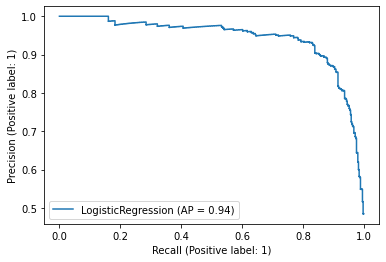

In [17]:
# Remember to comment them out before submitting the notebook

from sklearn.metrics import plot_precision_recall_curve

log_reg = LogisticRegression().fit(X_train, y_train)
disp = plot_precision_recall_curve(log_reg, X_test, y_test)
del log_reg, disp

### Question 6. (15 pts)

Perform a grid search over the hyper-parameters listed below for a Logistic Regression classifier, optimizing for classifier **precision** for scoring and five-fold cross validation. 

**Note: Use the following parameter settings for the logistic regression:**
 * Use the 'liblinear' solver, which supports both L1 and L2 regularization.
 * Set `random_state=42`, since the solver uses randomization internally.

`'penalty': ['l1', 'l2']`

`'C':[0.005, 0.01, 0.05, 0.1, 1, 10]`

From `.cv_results_`, create an array of the mean test scores for each hyper-parameter combination. i.e.

|   `C`   	| `l1` 	| `l2` 	|
|:----:	|----	|----	|
| **`0.005`** 	|    ?	|   ? 	|
| **`0.01`** 	|    ?	|   ? 	|
| **`0.05`** 	|    ?	|   ? 	|
| **`0.1`**  	|    ?	|   ? 	|
| **`1`**    	|    ?	|   ? 	|
| **`10`**   	|    ?	|   ? 	|

<br>

*This function should return a 6 by 2 numpy array of floats that contain the values for each "?" above. Do not return a pd.DataFrame.*

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def answer_six():    
    mean_test_scores = None
    
    grid_values = {'penalty':['l1','l2'],'C':[0.005, 0.01, 0.05, 0.1, 1, 10]}
    logreg = LogisticRegression(solver = 'liblinear',random_state=42).fit(X_train, y_train)

    grid_logreg = GridSearchCV(logreg,param_grid = grid_values, scoring = 'precision')

    grid_logreg.fit(X_train, y_train)

    vals = grid_logreg.cv_results_
    mean_test_scores = vals['mean_test_score'].reshape(6,2)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return mean_test_scores

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid_values = {'penalty':['l1','l2'],'C':[0.005, 0.01, 0.05, 0.1, 1, 10]}
logreg = LogisticRegression(solver = 'liblinear',random_state=42).fit(X_train, y_train)

grid_logreg = GridSearchCV(logreg,param_grid = grid_values, scoring = 'precision')

grid_logreg.fit(X_train, y_train)

vals = grid_logreg.cv_results_
vals['mean_test_score'].reshape(6,2)




array([[0.86896499, 0.91596042],
       [0.90477913, 0.91791225],
       [0.92880536, 0.92266374],
       [0.93051486, 0.92124649],
       [0.92606445, 0.92687087],
       [0.92336704, 0.92308448]])

In [20]:
# Autograder tests

stu_ans = answer_six()
assert isinstance(stu_ans, np.ndarray), "Q6: Your function should return a np.ndarray. "
assert stu_ans.shape == (6, 2), "Q6: Your np.ndarray should be of shape (6, 2). "

del stu_ans 

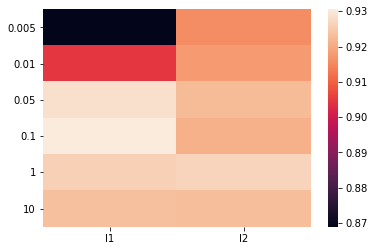

In [21]:
# Optional: use the following function to help visualise the results from the grid search

def GridSearch_Heatmap(scores):
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    plt.figure()
    sns.heatmap(scores.reshape(6, 2), xticklabels=['l1','l2'], yticklabels=[0.005, 0.01, 0.05, 0.1, 1, 10])
    plt.yticks(rotation=0);

# Remember to comment it out before submitting the notebook
GridSearch_Heatmap(answer_six())

### Question 7. Normalizing features when using regularization (5 pts)

Now re-run the code from Question 6 above, but using the raw *unnormalized* training data (i.e. X_train_raw as computed previously as part of Q1.). Return the *highest* precision you obtained from cross-validation in Q6 using normalized features, and the *highest* precision you obtain with the raw, unnormalized features. 

Your function should return a two-element tuple of floats `(best_precision_normalized, best_precision_unnormalized)`

It is very instructive to compare the results from (a) using correctly normalized features, vs. (b) forgetting to normalize the features and (c) the dummy baseline you computed in Q2.


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def answer_seven():    
    best_precision_normalized = None
    best_precision_unnormalized = None
    
    #Normed
    grid_values = {'penalty':['l1','l2'],'C':[0.005, 0.01, 0.05, 0.1, 1, 10]}
    logreg = LogisticRegression(solver = 'liblinear',random_state=42).fit(X_train, y_train)

    grid_logreg = GridSearchCV(logreg,param_grid = grid_values, scoring = 'precision')

    grid_logreg.fit(X_train, y_train)

    best_precision_normalized = grid_logreg.best_score_
    
    #Unnormed
    grid_values = {'penalty':['l1','l2'],'C':[0.005, 0.01, 0.05, 0.1, 1, 10]}
    logreg = LogisticRegression(solver = 'liblinear',random_state=42).fit(X_train_raw, y_train)

    grid_logreg = GridSearchCV(logreg,param_grid = grid_values, scoring = 'precision')

    grid_logreg.fit(X_train_raw, y_train)

    best_precision_unnormalized = grid_logreg.best_score_
    

    # YOUR CODE HERE
#     raise NotImplementedError()
    
    return (best_precision_normalized, best_precision_unnormalized)

In [23]:
# Autograder tests

stu_ans = answer_seven()

assert isinstance(stu_ans, tuple), "Q7: Your function should return a tuple. "
assert len(stu_ans) == 2, "Q7: The length of your returned tuple should be 2. "
assert all([isinstance(item, float) for item in stu_ans]), "Q7: Your tuple should only contain floats. "

del stu_ans